In [106]:
import numpy as np
from matplotlib import pyplot as plt

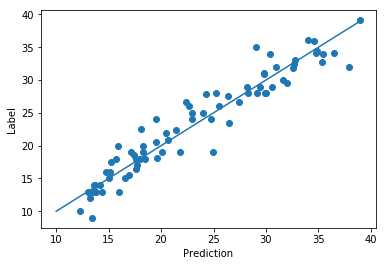

In [107]:
reader = np.load('mpg.npz')
prediction = reader['prediction']
label = reader['label']
make = reader['make']

plt.scatter(prediction, label)
plt.plot(range(10, 40), range(10, 40))
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

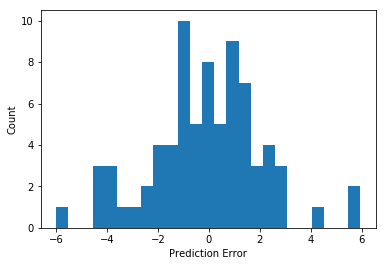

In [108]:
error = prediction - label
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.show()

In [109]:
def hoeffding_interval(samples, a, b, zeta=0.01):
    size = (b-a) * np.sqrt(2. / samples.shape[0] * np.log(1. / zeta))
    return np.mean(samples) - size, np.mean(samples) + size

def chebychev_interval(samples, sigma, zeta=0.005):
    size = sigma / np.sqrt(samples.shape[0] * zeta)
    return np.mean(samples) - size, np.mean(samples) + size

def compute_size(zeta, m, k):
    stuffs = []
    stuff = 1 - (zeta ** (1. / (m-k))) / ((1+m) ** (k/(m-k)))
    for i in range(10):
        stuffs.append(stuff)
        stuff = 1 - (zeta ** (1. / (m-k))) / ((1+m * stuff) ** (k/(m-k))) 
    return stuff

# Compute the confidence interval given a set of samples. All the samples are bounded in [a, b]
# Use the k-th largest element (i.e. k=0 is using the smallest/largest)
# Output the estimated lower bound and upper bound at required confidence (1-zeta)
def order_interval_bounded(samples, a, b, k=1, zeta=0.01):
    size = compute_size(zeta, samples.shape[0], k)
    samples = np.sort(samples)
    xmin = samples[k]
    xmax = samples[-k-1]
    return xmin - size * (xmin - a), xmax + size * (b - xmax)

# Compute the confidence interval given a set of samples.
# Assume the distribution has bounded 2nd moment sigma^2
def order_interval_moment(samples, sigma, k=1, zeta=0.005):
    size = compute_size(zeta, samples.shape[0], k)
    samples = np.sort(samples)
    xmin = samples[k]
    xmax = samples[-k-1]
    size = sigma * np.sqrt(size) / (1-size)
    return xmin - size, xmax + size

In [110]:
zeta = 0.01
a, b = -20, 20
sigma = np.sqrt(np.mean(np.square(error)) + np.sqrt(b ** 2 / 2 / error.shape[0] * np.log(4/zeta)))

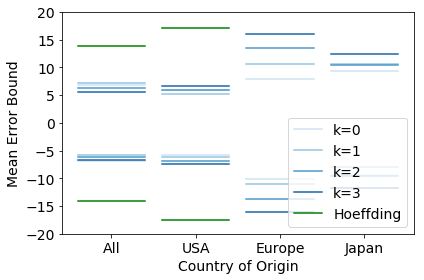

In [111]:
# Plot interval size under bounded assumptions
ks = [0, 1, 2, 3]
palette = sns.color_palette("Blues", len(ks))

values = [None, 1, 2, 3]
names = ['All', 'USA', 'Europe', 'Japan']

def make_plot(low, high, label, c, use_label=False):
    if not use_label:
        plt.plot(np.linspace(index+0.1, index+0.9, 100), 100 *[high], c=c)
    else:
        plt.plot(np.linspace(index+0.1, index+0.9, 100), 100 *[high], c=c, label=label)
    plt.plot(np.linspace(index+0.1, index+0.9, 100), 100 *[low], c=c)

def adjust_style():  
    plt.ylim([-20, 20])
    plt.xticks(0.5 + np.arange(len(values)), names, fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel('Mean Error Bound', fontsize=14)
    plt.xlabel('Country of Origin', fontsize=14)
    plt.legend(fontsize=14, loc=4)
    plt.tight_layout()
    
for index, val in enumerate(values):
    if val is None:
        errs = error
    else:
        errs = error[make == val]
    
    for ki, k in enumerate(ks):
        low, high = order_interval_bounded(errs, a=a, b=b, k=k, zeta=zeta)
        make_plot(low, high, label='k=%d' % k, c=palette[ki], use_label=(index == 0))
    
    low, high = hoeffding_interval(errs, a=a, b=b, zeta=zeta)
    make_plot(low, high, label='Hoeffding', c='g', use_label=(index == 0))
    
adjust_style()
plt.savefig('mpg_example_hoeffding.png')
plt.show()

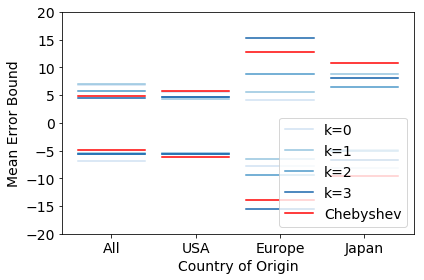

In [112]:
# Plot interval size under bounded moment assumptions
for index, val in enumerate(values):
    if val is None:
        errs = error
    else:
        errs = error[make == val]
    
    for ki, k in enumerate(ks):
        # zeta needs to be smaller for chebyshev because the upper bound on sigma is true only with 1-zeta/2 probability
        low, high = order_interval_moment(errs, sigma=sigma, k=k, zeta=zeta/2)
        make_plot(low, high, label='k=%d' % k, c=palette[ki], use_label=(index == 0))
    
    low, high = chebychev_interval(errs, sigma=sigma, zeta=zeta/2)
    make_plot(low, high, label='Chebyshev', c='r', use_label=(index == 0))
    
adjust_style()
plt.savefig('mpg_example_chebyshev.png')
plt.show()

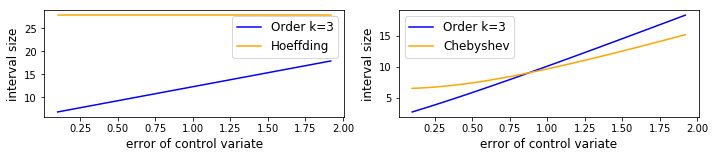

In [113]:
plt.figure(figsize=(10, 2.3))
for i, bound_type in enumerate(['bounded', 'moments']):
    plt.subplot(1, 2, i+1)
    order_list = []
    baseline_list = []
    ratio_list = []
    errs = error
    cur_ratio = 0.1
    
    for i in range(32):
        a = -20
        b = 20
        serrs = errs * cur_ratio
        sigma = np.sqrt(np.mean(np.square(serrs)) +\
                        np.sqrt(b ** 2 / 2 / serrs.shape[0] * np.log(4/zeta)))

        if bound_type == 'moments':
            low, high = order_interval_moment(serrs, k=3, sigma=sigma, zeta=zeta/2)
        else:
            low, high = order_interval_bounded(serrs, k=3, a=a, b=b, zeta=zeta)
        order_list.append(high - low)
        if bound_type == 'moments':   
            low, high = chebychev_interval(serrs, sigma=sigma, zeta=zeta/2)
        else:
            low, high = hoeffding_interval(serrs, a=a, b=b, zeta=zeta)
        baseline_list.append(high - low)
        ratio_list.append(cur_ratio)

        cur_ratio = cur_ratio * 1.1

    plt.plot(ratio_list, order_list, c='b', label='Order k=3')
    if bound_type == 'moments':
        plt.plot(ratio_list, baseline_list, c='orange', label='Chebyshev')
    else:
        plt.plot(ratio_list, baseline_list, c='orange', label='Hoeffding')
    plt.legend(fontsize=12)
    plt.xlabel('error of control variate', fontsize=12)
    plt.ylabel('interval size', fontsize=12)
plt.tight_layout()
plt.savefig('bound_vs_error.pdf')
plt.show()